<a href="https://colab.research.google.com/github/DangTuanNinh/TrafficSignDetection/blob/main/TrafficSignDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cp /content/drive/MyDrive/traffic_sign_detection.zip .

In [5]:
!unzip ./traffic_sign_detection.zip

Archive:  ./traffic_sign_detection.zip
  inflating: annotations/road0.xml   
  inflating: annotations/road1.xml   
  inflating: annotations/road10.xml  
  inflating: annotations/road100.xml  
  inflating: annotations/road101.xml  
  inflating: annotations/road102.xml  
  inflating: annotations/road103.xml  
  inflating: annotations/road104.xml  
  inflating: annotations/road105.xml  
  inflating: annotations/road106.xml  
  inflating: annotations/road107.xml  
  inflating: annotations/road108.xml  
  inflating: annotations/road109.xml  
  inflating: annotations/road11.xml  
  inflating: annotations/road110.xml  
  inflating: annotations/road111.xml  
  inflating: annotations/road112.xml  
  inflating: annotations/road113.xml  
  inflating: annotations/road114.xml  
  inflating: annotations/road115.xml  
  inflating: annotations/road116.xml  
  inflating: annotations/road117.xml  
  inflating: annotations/road118.xml  
  inflating: annotations/road119.xml  
  inflating: annotations/road

In [6]:
import time
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib . pyplot as plt
import xml. etree . ElementTree as ET

from skimage . transform import resize
from skimage import feature
from sklearn .svm import SVC
from sklearn . preprocessing import LabelEncoder
from sklearn . preprocessing import StandardScaler
from sklearn . model_selection import train_test_split
from sklearn . metrics import accuracy_score

In [9]:
annotations_dir = "annotations"
img_dir = "images"

img_lst = []
label_lst = []

for xml_file in os.listdir (annotations_dir):
    xml_filepath= os.path.join(annotations_dir, xml_file)
    tree = ET.parse(xml_filepath)
    root = tree.getroot()

    folder = root.find('folder').text
    img_filename = root.find('filename').text
    img_filepath = os.path.join(img_dir, img_filename)
    img= cv2.imread(img_filepath)

    for obj in root.findall('object'):
        classname = obj.find('name').text
        if classname == 'trafficlight':
            continue

        xmin = int(obj.find('bndbox/xmin').text)
        ymin = int(obj.find('bndbox/ymin').text)
        xmax = int(obj.find('bndbox/xmax').text)
        ymax = int(obj.find('bndbox/ymax').text)

        object_img = img[ymin:ymax, xmin:xmax]
        img_lst.append(object_img)
        label_lst.append(classname)

print("Number of objects: ",len(img_lst))
print("Class names: ",list(set(label_lst)))

Number of objects:  1074
Class names:  ['speedlimit', 'crosswalk', 'stop']


In [12]:
def preprocess_img (img ) :
    if len(img. shape ) > 2:
        img = cv2. cvtColor (img ,cv2 . COLOR_BGR2GRAY)
    img = img. astype (np. float32 )

    resized_img = resize (img ,output_shape =(32 , 32) ,anti_aliasing = True)

    hog_feature = feature .hog(
        resized_img,
        orientations =9,
        pixels_per_cell =(8 , 8),
        cells_per_block =(2 , 2),
        transform_sqrt =True ,
        block_norm ="L2",
        feature_vector = True
    )
    return hog_feature

img_features_lst = []
for img in img_lst :
    hog_feature = preprocess_img(img)
    img_features_lst.append (hog_feature)

img_features = np.array(img_features_lst)
print("X shape:")
print(img_features.shape)

X shape:
(1074, 324)


In [13]:
label_encoder = LabelEncoder ()
encoded_labels = label_encoder.fit_transform(label_lst)

In [14]:
random_state = 0
test_size = 0.3
is_shuffle = True

X_train , X_val , y_train , y_val = train_test_split (
    img_features , encoded_labels ,
    test_size = test_size ,
    random_state = random_state ,
    shuffle = is_shuffle
)

In [15]:
scaler = StandardScaler ()
X_train = scaler . fit_transform ( X_train )
X_val = scaler . transform ( X_val )

In [18]:
clf = SVC(
    kernel = "rbf",
    random_state = random_state,
    probability =True,
    C =0.5
)
clf.fit(X_train , y_train )

SVC(C=0.5, probability=True, random_state=0)

In [19]:
y_pred = clf . predict ( X_val )
score = accuracy_score (y_pred , y_val )

print ("Evaluation results on val set")
print ("Accuracy :", score )

Evaluation results on val set
Accuracy : 0.9721362229102167


In [33]:
def sliding_window (img , window_sizes , stride , scale_factor ) :
    img_height , img_width = img. shape [:2]
    windows = []
    for window_size in window_sizes :
        window_width , window_height = window_size
        for ymin in range (0 , img_height - window_height + 1 , stride ) :
            for xmin in range (0 , img_width - window_width + 1 , stride ) :
                xmax = xmin + window_width
                ymax = ymin + window_height

                windows.append ([ xmin , ymin , xmax , ymax ])

    return windows

In [21]:
def pyramid (img , scale =0.8 , min_size =(30 , 30) ) :
    acc_scale = 1.0
    pyramid_imgs = [( img , acc_scale ) ]

    while True :
        acc_scale = acc_scale * scale
        h = int (img. shape [0] * acc_scale )
        w = int (img. shape [1] * acc_scale )
        if h < min_size [1] or w < min_size [0]:
            break
    img = cv2. resize (img , (w, h) )
    pyramid_imgs . append (( img , acc_scale ) )

    return pyramid_imgs

In [31]:
def visualize_bbox (img , bboxes , label_encoder ):
    img = cv2. cvtColor (img , cv2.COLOR_BGR2RGB )

    for box in bboxes :
        xmin , ymin , xmax , ymax , predict_id , conf_score = box

        cv2.rectangle(img , (xmin , ymin ) , (xmax , ymax ) , (0 , 255 , 0) , 2)

        classname = label_encoder.inverse_transform ([ predict_id ]) [0]
        label = f"{ classname } { conf_score :.2f}"

        (w, h) , _ = cv2. getTextSize (label , cv2.FONT_HERSHEY_SIMPLEX , 0.6 , 1)

        cv2.rectangle (img , (xmin , ymin - 20) , ( xmin + w, ymin ) , (0 , 255 , 0) , -1)

        cv2.putText (img , label , (xmin , ymin - 5) , cv2.FONT_HERSHEY_SIMPLEX , 0.6 , (0 , 0 , 0) , 1)

    plt.imshow (img)
    plt.axis ("off")
    plt.show ()

In [23]:
def compute_iou (bbox , bboxes , bbox_area , bboxes_area ):
    xxmin = np. maximum ( bbox [0] , bboxes [: , 0])
    yymin = np. maximum ( bbox [1] , bboxes [: , 1])
    xxmax = np. minimum ( bbox [2] , bboxes [: , 2])
    yymax = np. minimum ( bbox [3] , bboxes [: , 3])

    w = np. maximum (0 , xxmax - xxmin + 1)
    h = np. maximum (0 , yymax - yymin + 1)

    intersection = w * h
    iou = intersection / ( bbox_area + bboxes_area - intersection )

    return iou

In [27]:
def nms(bboxes , iou_threshold ):
    if not bboxes :
        return []

    scores = np. array ([ bbox [5] for bbox in bboxes ])
    sorted_indices = np. argsort ( scores ) [:: -1]

    xmin = np. array ([ bbox [0] for bbox in bboxes ])
    ymin = np. array ([ bbox [1] for bbox in bboxes ])
    xmax = np. array ([ bbox [2] for bbox in bboxes ])
    ymax = np. array ([ bbox [3] for bbox in bboxes ])

    areas = ( xmax - xmin + 1) * ( ymax - ymin + 1)

    keep = []

    while sorted_indices . size > 0:
        i = sorted_indices [0]
        keep.append(i)

        iou = compute_iou (
            [xmin [i] , ymin [i] , xmax [i] , ymax [i]] ,
            np. array (
                [
                    xmin [ sorted_indices [1:]] ,
                    ymin [ sorted_indices [1:]] ,
                    xmax [ sorted_indices [1:]] ,
                    ymax [ sorted_indices [1:]]]
            ).T,
            areas [i] ,
            areas [ sorted_indices [1:]]
        )

        idx_to_keep = np. where (iou <= iou_threshold ) [0]
        sorted_indices = sorted_indices [ idx_to_keep + 1]

    return [ bboxes [i] for i in keep ]

['road456.png']
images/road456.png


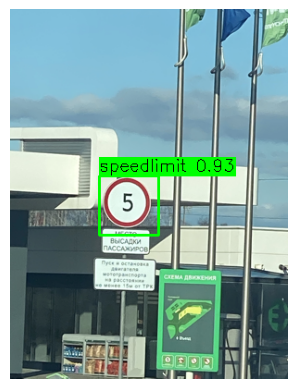

Time process: 4.420486211776733


In [51]:
img_dir = "images"
img_filename_lst = os.listdir(img_dir)[:1]
print(img_filename_lst)
conf_threshold = 0.9
iou_threshold = 0.5
stride = 12
window_sizes = [
    (32 , 32) ,
    (64 , 64) ,
    (128 , 128)
]

for img_filename in img_filename_lst :
    start_time = time.time ()
    img_filepath = os.path.join (img_dir , img_filename )
    print(img_filepath)
    bboxes = []
    img = cv2.imread(img_filepath )
    pyramid_imgs = pyramid(img)

    for pyramid_img_info in pyramid_imgs :
        pyramid_img , scale_factor = pyramid_img_info
        window_lst = sliding_window(
            pyramid_img,
            window_sizes = window_sizes ,
            stride =stride,
            scale_factor = scale_factor
        )

        for window in window_lst :
            xmin , ymin , xmax , ymax = window
            object_img = pyramid_img [ ymin :ymax , xmin : xmax ]
            preprocessed_img = preprocess_img (object_img)
            normalized_img = scaler.transform ([ preprocessed_img ]) [0]
            decision = clf.predict_proba ([ normalized_img ]) [0]
            if np.all( decision < conf_threshold ):
                continue
            else :
                predict_id = np. argmax ( decision )
                conf_score = decision [ predict_id ]
                xmin = int( xmin / scale_factor )
                ymin = int( ymin / scale_factor )
                xmax = int( xmax / scale_factor )
                ymax = int( ymax / scale_factor )
                bboxes.append (
                    [xmin , ymin , xmax , ymax , predict_id , conf_score ]
                )
    bboxes = nms(bboxes, iou_threshold)
    visualize_bbox(img, bboxes, label_encoder)

    print("Time process:", time.time() - start_time)